In [1]:
!pip install -q transformers
!pip install -q bitsandbytes
!pip install -q peft
!pip install -q torch
!pip install -q accelerate -U

In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments


import os
import torch
import torch.nn as nn
import bitsandbytes as bnb
import transformers
import peft
from peft import LoraConfig, IA3Config, get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType

In [3]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

## **Ia3 Setup**

In [5]:
# Freezing the model
for param in model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [6]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [7]:
# Setup IA3 Config
print(model)

config = IA3Config(
    peft_type="IA3",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): CastOutputToFloat(
    (0): Linear(in_features=768, out_features=50257, bias=False)
  )
)


/usr/local/lib/python3.10/dist-packages/peft/tuners/ia3/model.py:155: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 64512 || all params: 124504320 || trainable%: 0.051815069549393945


## **Data Loading and Tokenization**

In [8]:
data = []
with open("parsed_quotes_context.txt") as sherlock_quotes_file:
    lines = sherlock_quotes_file.readlines()
    for i in range(0, len(lines), 3):
        if i + 1 < len(lines):
            concatenated_lines = f"{lines[i].strip()} ->: {lines[i+1].strip()}"
            data.append(concatenated_lines)


In [9]:
print(data[0])

I say, Holmes -- I wish you'd stop that caterwauling. ->: Hmpf!


In [10]:
tokenizer.pad_token = tokenizer.eos_token

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=50)

train_data = [tokenizer(line) for line in train_data]
val_data = [tokenizer(line) for line in val_data]

In [12]:
# To instead load a pretrained model:

# model = GPT2LMHeadModel.from_pretrained("gpt2-sherlock-v0")

## **Training**

In [13]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=1000,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        evaluation_strategy="steps",
        eval_steps=20,
        output_dir='outputs',
        save_steps=250,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
20,4.588300,4.185330
40,4.569100,4.175136
60,4.432000,4.159391
80,4.406900,4.139835
100,4.447400,4.116286
120,4.354300,4.091505
140,4.226000,4.068415
160,4.119500,4.045321
180,4.341600,4.025112
200,4.208700,4.005286


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=1000, training_loss=4.08626422739029, metrics={'train_runtime': 431.5116, 'train_samples_per_second': 37.079, 'train_steps_per_second': 2.317, 'total_flos': 648679588208640.0, 'train_loss': 4.08626422739029, 'epoch': 23.39})

## **Sampling**

In [14]:
from transformers import set_seed

set_seed(40)

device = model.device
batch = tokenizer("How can we find the culprit? ->: ", return_tensors='pt')
batch.to(device)

sample_outputs = model.generate(
    **batch,
    max_new_tokens=125,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1,
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: How can we find the culprit? ->: *********** (G-G-Yes, you're coming in from outside.) *********** (G-You're going to get stuck here.) (O-Okay.) "Truly, it will be a great help if they find him." Oh? What do you mean? He isn't really there? Well, it's not like he's been taken hostage. But he might well be. I'm sure she's got a plan and can solve this. (As the two of them walk back to the office, G-Gentleman, go straight to Mr. Bostwick's desk.) I've


In [15]:
# To save the model

# model.save_pretrained("gpt2-sherlock-v0", from_pt=True)

## **Graphs and Visualizations**

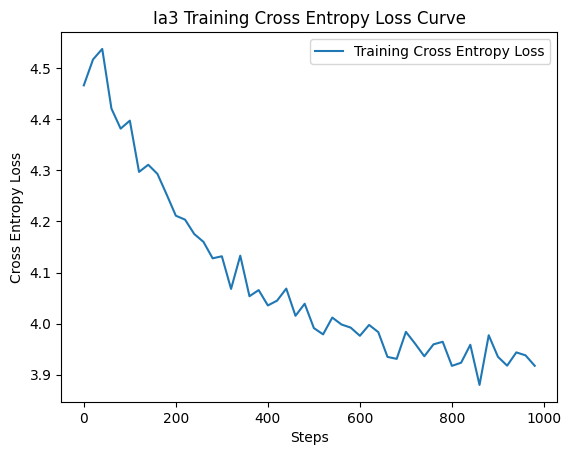

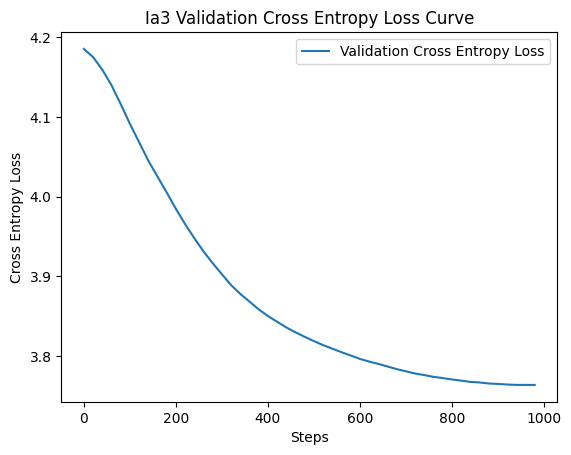

In [18]:
import matplotlib.pyplot as plt

train_loss_values = []
val_loss_values = []

# Access the training and val loss values from the Trainer's log
for i, x in enumerate(trainer.state.log_history[:-1]):
  if (i+1) % 21 == 0:
    val_loss_values.append(x["eval_loss"])
  else:
    train_loss_values.append(x["loss"])
train_loss_values = [sum(train_loss_values[i:i+20]) / 20 for i in range(0, len(train_loss_values), 20)]

# Plot the training loss curve
plt.plot(train_loss_values, label="Training Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Ia3 Training Cross Entropy Loss Curve")
plt.legend()
plt.show()

# Plot the val loss curve
plt.plot(val_loss_values, label="Validation Cross Entropy Loss")
plt.xlabel("Steps")
plt.xticks([0, 10, 20, 30, 40, 50], [0, 200, 400, 600, 800, 1000])
plt.ylabel("Cross Entropy Loss")
plt.title("Ia3 Validation Cross Entropy Loss Curve")
plt.legend()

In [25]:
final_train_loss = trainer.state.log_history[-3]['loss']
final_val_loss = trainer.state.log_history[-2]['eval_loss']
print("Final train loss: ", final_train_loss)
print("Final val loss: ", final_val_loss)

Final train loss:  3.8987
Final val loss:  3.7635834217071533
